Installing tfds (tensorflow dataset) :

In [1]:
!pip install -q tfds-nightly
!tfds --version

     |████████████████████████████████| 3.7MB 5.6MB/s 
2020-12-08 12:52:54.266019: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
TensorFlow Datasets: 4.1.0+nightly


Clone the source repo from GitHub

In [2]:
!git clone "https://github.com/heolfief/Where_is_Waldo_AI_solver.git"

Cloning into 'Where_is_Waldo_AI_solver'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 79 (delta 24), reused 48 (delta 10), pack-reused 0
Unpacking objects: 100% (79/79), done.


Create the images for the dataset

In [3]:
!python Where_is_Waldo_AI_solver/scripts/image_cutter.py

Warning, the following process may be quite long
100% 18/18 [00:14<00:00,  1.22it/s]


Building the dataset from the python script:

In [4]:
!tfds build Where_is_Waldo_AI_solver/scripts/create_TFDS.py --overwrite

2020-12-08 12:53:19.751344: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-08 12:53:22.135939: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2020-12-08 12:53:22.339521: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
I1208 12:53:22.526261 139681925023616 build.py:345] download_and_prepare for dataset waldo_dataset/1.0.0...
I1208 12:53:22.528699 139681925023616 dataset_builder.py:393] Generating dataset waldo_dataset (/root/tensorflow_datasets/waldo_dataset/1.0.0)
2020-12-08 12:53:22.600697: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
202

Testing the dataset :

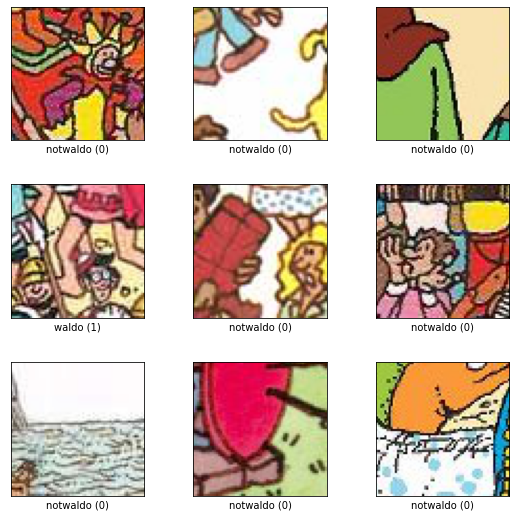

tfds.core.DatasetInfo(
    name='waldo_dataset',
    version=1.0.0,
    description='Where is Waldo dataset',
    homepage='https://github.com/heolfief/Where_is_Waldo_AI_solver',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7952,
    splits={
        'train': 7952,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



In [9]:
import tensorflow_datasets as tfds
ds, ds_info = tfds.load('waldo_dataset', split='train', with_info=True,  shuffle_files=True, as_supervised=True)
fig = tfds.show_examples(ds, ds_info)
print(ds_info)


In [15]:
# Recover the size of the whole dataset
ds_size = ds.cardinality().numpy()
# Define sizes for train and test sets
train_size = int(0.7 * ds_size)
val_size = int(0.15 * ds_size)
test_size = int(0.15 * ds_size)

# Define train and test sets according to sizes
train_dataset = ds.take(train_size)
temp = ds.skip(train_size)

test_dataset = temp.take(test_size)
val_dataset = temp.skip(test_size)

OrderedDict([(0, 6755), (1, 1195)])
OrderedDict([(0, 4729), (1, 835)])
OrderedDict([(0, 1010), (1, 180)])


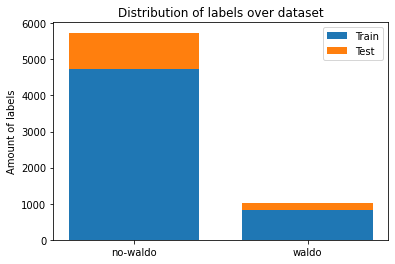

In [32]:
import collections
import numpy as np
import matplotlib.pyplot as plt

# Recover distribution of classes among datasets
def get_class_distribution(dataset):
    class_distribution = {}
    for element in dataset.as_numpy_iterator():
        label = element[1]

        if label in class_distribution.keys():
            class_distribution[label] += 1
        else:
            class_distribution[label] = 0

    # sort dict by key
    class_distribution = collections.OrderedDict(sorted(class_distribution.items())) 
    return class_distribution

train_distribution = get_class_distribution(train_dataset)
test_distribution = get_class_distribution(test_dataset)

# Plot distribution
indices = np.arange(len(train_distribution))
width = 0.75
train_plot = []
test_plot = []
for label, amount in train_distribution.items():
  train_plot.append(amount)
for label, amount in test_distribution.items():
  test_plot.append(amount)

p1 = plt.bar(indices, train_plot, width)
p2 = plt.bar(indices, test_plot, width, bottom=train_plot)
plt.ylabel('Amount of labels')
plt.title('Distribution of labels over dataset')
plt.xticks(indices, ('no-waldo', 'waldo'))
l = plt.legend((p1[0], p2[0]), ('Train', 'Test'))
plt.show()

**Build CNN :**

In the menu "Execution" -> modify execution type and select GPU. Once execution type is correctly configured, the GPU model should appaers below 

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Load dataset in a dataset class :

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout,Flatten
import time

train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(32)
test_dataset = test_dataset.shuffle(1000)
test_dataset = test_dataset.batch(32)

In [ ]:
CNN = Sequential()
CNN.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(64,64,3)))
CNN.add(MaxPooling2D(pool_size=(2, 2)))

CNN.add(Conv2D(32, (5, 5), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))

CNN.add(Flatten())
# add 3 hiden layers 
# TO DO
CNN.add(Dense(units=84, activation='tanh'))
CNN.add(Dense(units=2, activation='softmax'))
#CNN.add(Dense(units=10, activation='softmax'))

CNN.summary()

CNN.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)



CNN.fit(train_dataset, epochs=100, validation_data=test_dataset)


In [ ]:

print("Evaluate on test data")
results = CNN.evaluate(test_dataset)
print("test loss, test acc:", results)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

y_pred=CNN.predict_classes(test_dataset)
true_categories = tf.concat([y for x, y in test_dataset], axis=0)
con_mat = tf.math.confusion_matrix(labels=true_categories, predictions=y_pred).numpy()
print(con_mat)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
classes = [0, 1]
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
